In [2]:
%matplotlib inline
from PIL import Image
import sys
from IPython import display
import matplotlib.pyplot as plt
from mxnet import contrib,gluon,image,nd
import numpy as np
np.set_printoptions(2)

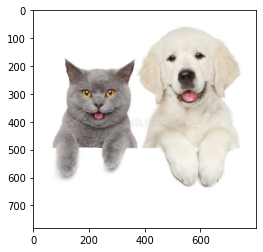

In [7]:
def set_figsize():
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = (6,6)
img = Image.open('/home/data/cat_and_dog.jpg')
plt.imshow(img);

In [9]:
cat_bbox,dog_bbox =[60,180,378,600],[410,70,750,640]
def bbox_to_rect(bbox,color):
    xy = (bbox[0],bbox[1])
    width = bbox[2]-bbox[0]
    height = bbox[3]-bbox[1]
    return plt.Rectangle(xy,width,height,fill=False,edgecolor=color,linewidth=2)

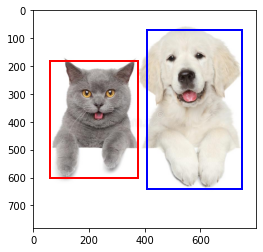

In [10]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox,'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox,'red'))

In [11]:
img = image.imread('/home/data/cat_and_dog.jpg').asnumpy()
h,w = img.shape[0:2]
print(h,w)
X = nd.random.uniform(shape=(1,3,h,w))
Y = contrib.nd.MultiBoxPrior(X,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5])
Y.shape
boxes = Y.reshape((h,w,5,4))
boxes.shape
boxes[250,250,:,:]

781 800



[[-0.05 -0.05  0.68  0.7 ]
 [ 0.07  0.07  0.56  0.57]
 [ 0.19  0.2   0.44  0.45]
 [-0.2   0.06  0.83  0.59]
 [ 0.05 -0.21  0.57  0.85]]
<NDArray 5x4 @cpu(0)>

In [13]:
def show_bboxes(axes,bboxes,labels=None,colors=None):
    def _make_list(obj,default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj,(list,tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors,['b','g','r','m','c'])
    for i,bbox in enumerate(bboxes):
        color = colors[i%len(colors)]
        rect = bbox_to_rect(bbox.asnumpy(),color)
        axes.add_patch(rect)
        if labels and len(labels)>i:
            text_color = 'k' if color=='w'else 'w'
            axes.text(rect.xy[0],rect.xy[1],labels[i],va='center',ha='center',
                    fontsize=9,color=text_color,bbox=dict(facecolor=color,lw=0))

/tmp/ipykernel_645/1691205507.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


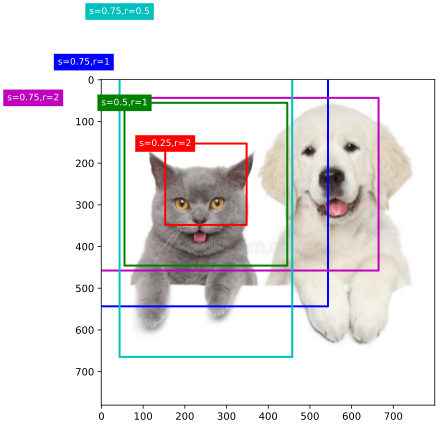

In [14]:
set_figsize()
bbox_scale = nd.array((w,h,w,h))
fig = plt.imshow(img)
show_bboxes(fig.axes,boxes[250,250,:,:]*bbox_scale,['s=0.75,r=1','s=0.5,r=1','s=0.25,r=2','s=0.75,r=2','s=0.75,r=0.5'])

(5, 4)


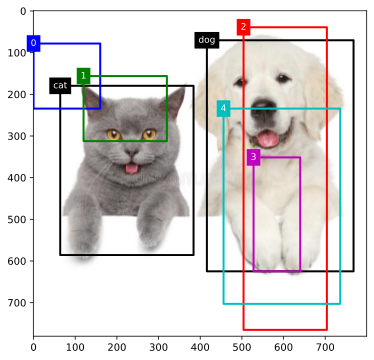

In [16]:
groud_truth = nd.array([[1,0.08,0.23,0.48,0.75],
                        [0,0.52,0.09,0.96,0.8]])
anchors = nd.array([[0,0.1,0.2,0.3],[0.15,0.2,0.4,0.4],
                    [0.63,0.05,0.88,0.98],[0.66,0.45,0.8,0.8],
                    [0.57,0.3,0.92,0.9]])
fig = plt.imshow(img)
show_bboxes(fig.axes,groud_truth[:,1:]*bbox_scale,['cat','dog'],'k')
show_bboxes(fig.axes,anchors*bbox_scale,['0','1','2','3','4'])
print(anchors.shape)

In [20]:
labels = contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0),groud_truth.expand_dims(axis=0),nd.zeros((1,3,5)))

In [28]:
print(anchors.shape)
print(groud_truth.shape)
labels[1]

(5, 4)
(2, 5)



[[0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]
<NDArray 1x20 @cpu(0)>

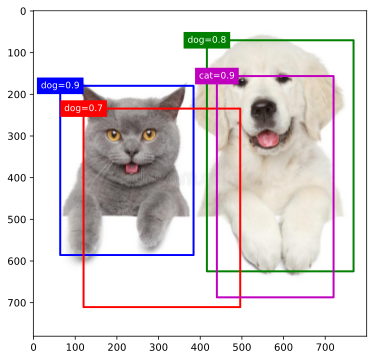

In [31]:
anchors = nd.array([[0.08,0.23,0.48,0.75],
                        [0.52,0.09,0.96,0.8],
                        [0.15,0.3,0.62,0.91],[0.55,0.2,0.9,0.88]])
offset_preds = nd.array([0]*anchors.size)
cls_probs = nd.array([[0]*4,[0.9,0.8,0.7,0.1],[0.1,0.2,0.3,0.9]])
fig = plt.imshow(img)
show_bboxes(fig.axes,anchors*bbox_scale,['dog=0.9','dog=0.8','dog=0.7','cat=0.9'])

In [32]:
output = contrib.ndarray.MultiBoxDetection(cls_probs.expand_dims(axis=0),offset_preds.expand_dims(axis=0),anchors.expand_dims(axis=0),nms_threshold=0.5 )
output


[[[0.   0.9  0.08 0.23 0.48 0.75]
  [1.   0.9  0.55 0.2  0.9  0.88]
  [0.   0.8  0.52 0.09 0.96 0.8 ]
  [0.   0.7  0.15 0.3  0.62 0.91]]]
<NDArray 1x4x6 @cpu(0)>